# Recipe2Cuisine

Classify recipies into different cuisine types based only on the ingredients>

In [1]:
import timeit
import spacy
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naiv
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier

nlp = spacy.load("en_core_web_sm")

In [2]:
recipies = pd.read_json('recipies.json')

In [3]:
recipies.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [37]:
recipies

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [4]:
recipies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


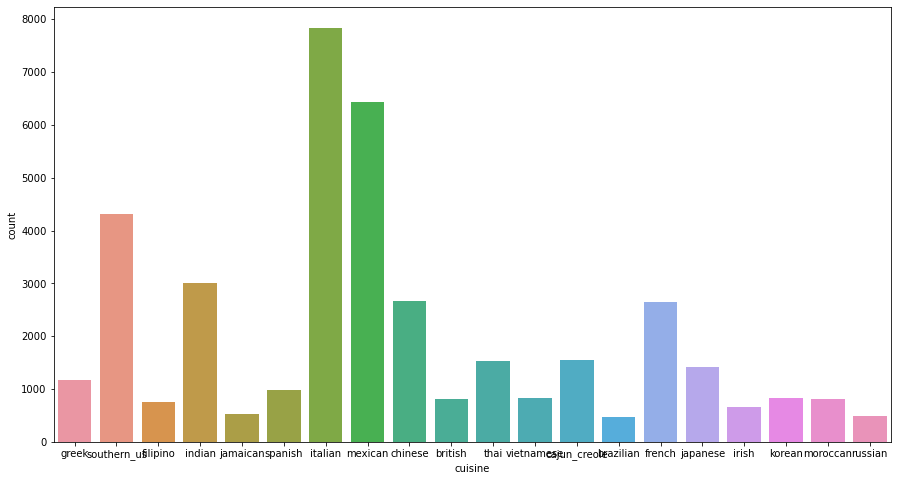

In [5]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(recipies.cuisine);

In [6]:
recipies.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [7]:
all_ingredients = pd.Series(ingredient for recipe in recipies.ingredients for ingredient in recipe)
all_ingredients.head()

0    romaine lettuce
1       black olives
2     grape tomatoes
3             garlic
4             pepper
dtype: object

In [8]:
print('Number of unique ingredients:', len(all_ingredients.unique()))

Number of unique ingredients: 6714


In [9]:
all_ingredients.value_counts()

salt                  18049
onions                 7972
olive oil              7972
water                  7457
garlic                 7380
                      ...  
instant tea powder        1
black radish              1
knorr pasta side          1
liquid sweetener          1
light margarine           1
Length: 6714, dtype: int64

In [71]:
def plot_custom_cm(estimator, X, y, normalize=False, fill_diag=False):
    """Plot a confusion matrix and return confusion matrix."""
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred)
    fmt='.0f'
    if normalize:
        cm = cm / cm.sum(axis=1, keepdims=True)
        fmt='.2f'
    if fill_diag:
        np.fill_diagonal(cm, 0)
    f, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(cm, annot=True, cmap="Blues", square=True, ax=ax, fmt=fmt)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    ax.set_xticklabels(estimator.classes_)
    ax.set_yticklabels(estimator.classes_)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

## Simple Bag of Words

In [11]:
ingredients = recipies['ingredients'].apply(' '.join)

In [65]:
X = ingredients.copy()
y = recipies.cuisine.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [66]:
bago = CountVectorizer()
X_train = bago.fit_transform(X_train)
X_test = bago.transform(X_test)

In [67]:
# Let's start with a simple baseline
clf = MultinomialNB()

In [68]:
cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.71603658, 0.724967  , 0.72119555])

In [69]:
clf.fit(X_train, y_train)

MultinomialNB()

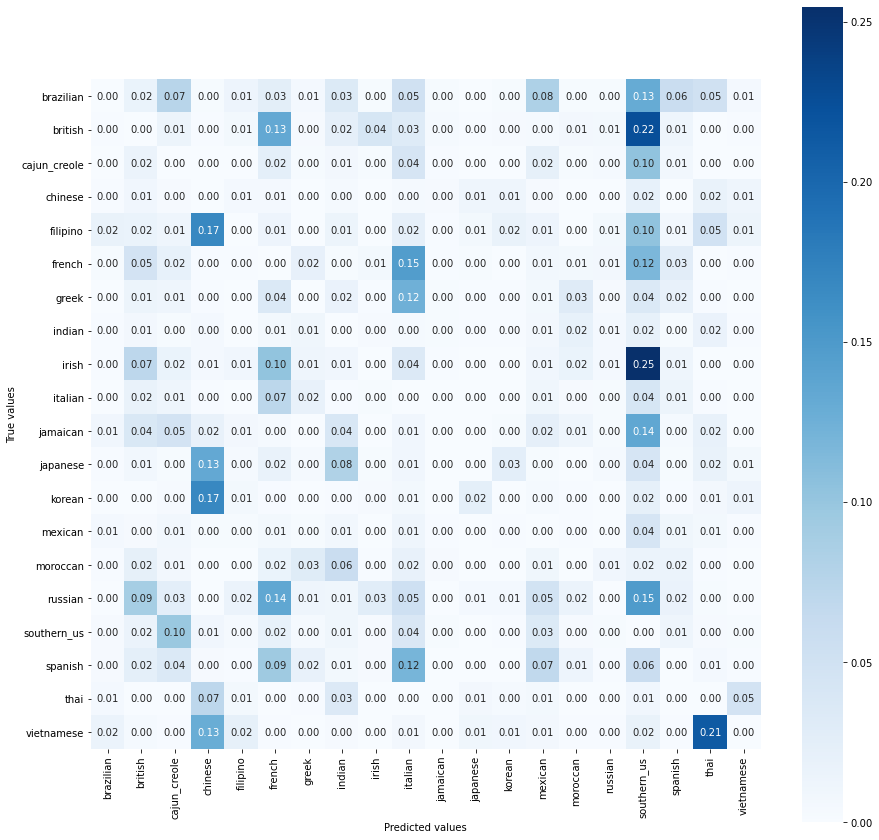

In [72]:
plot_custom_cm(clf, X_train, y_train, normalize=True, fill_diag=True);

I have around 72% accuracy and as expected most mistakes occur between closesly related cuisines like korean and chinese or italian and greek. We can try better approaches to improve the model.

To try:

* TF-IDF
* Other classifiers
* Lemmetize ingredients
* Remove stop words
* Remove additional stop words like descriptions of ingredients (chopped, baked, etc.)
* Remove brand names / named entities

## Text Processing

**I will try removing named entities, puncutations, stop words**

In [73]:
# Added stop words to remove weights and measures

blacklist = [
    'ounce', 'ounces', 'cups', 'cup', 'teaspoon', 'tablespoon', 'tablespoons',
    'teaspoons', 'c', 'g', 'v', 'tbsp', 'x', 'ml', 'lb', 'tbs', 'oz', 'pkg',
    'large', 'small', 'tsp', 'inch', 'grams', 'quarts', 'lbs', 'can', 'cube',
    'whole', 'or', 'pieces', 'piece', 'chopped', 'shredded', 'diced', 'fresh',
    'crushed', 'tsp', 'package', 'kg', 'kilogram', 'gallon', 'degree',
    'degrees', 'temperature', 'hot', 'warm', 'cold', 'boiling', 'lukewarm',
    'f', 'c', 'slice', 'sliced', 'fresh', 'freshly', 'pound', 'pounds', 'thin',
    'thinly', 'thick', 'thickly', 'coarsely', 'finely', 'jar', 'strip',
    'strips', 'cut', 'peeled', 'wedge', 'bitesize', 'according', 'direction',
    'optional', 'bite', 'size', 'half', 'pinch', 'dash', 'eg', 'frozen',
    'thawed', 'recipe', 'fat', 'quart', 'quarts', 'pint', 'pints', 'splash',
    'container', 'fried', 'cooked', 'uncooked', 'boiled', 'reduced', 'drained',
    'water', 'one', 'washed', 'rinsed', 'pitted', 'head', 'tube', 'fluid',
    'fl', 'preferably', 'bottle', 'diagonally', 'crosswise', 'lengthwise',
    'torn', 'serving', 'bunch', 'halved', 'part', 'quartered', 'available',
    'grocery', 'first', 'andor', 'substitution', 'bar', 'minced', 'granulated'
]

for word in blacklist:
    nlp.vocab[word].is_stop = True

# Tokenizem, remove stop words, named entities and lemmatize
tokens = []
lemma = []
for doc in nlp.pipe(ingredients.values):
    if doc.is_parsed:
        ents = [e.text for e in doc.ents]
        tokens.append([
            n.text for n in doc
            if (n.text not in ents) & (not n.is_punct) & (not n.is_stop)
        ])
        lemma.append([
            n.lemma_ for n in doc
            if (n.text not in ents) & (not n.is_punct) & (not n.is_stop)
        ])
    else:
        # To make sure length of lemma is same as original data
        # add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)

In [74]:
processed = pd.Series(tokens).apply(' '.join)

In [75]:
X = processed.copy()
y = recipies.cuisine.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [76]:
bago = CountVectorizer()
X_train = bago.fit_transform(X_train)
X_test = bago.transform(X_test)

In [77]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.70858867, 0.71459551, 0.71148407])

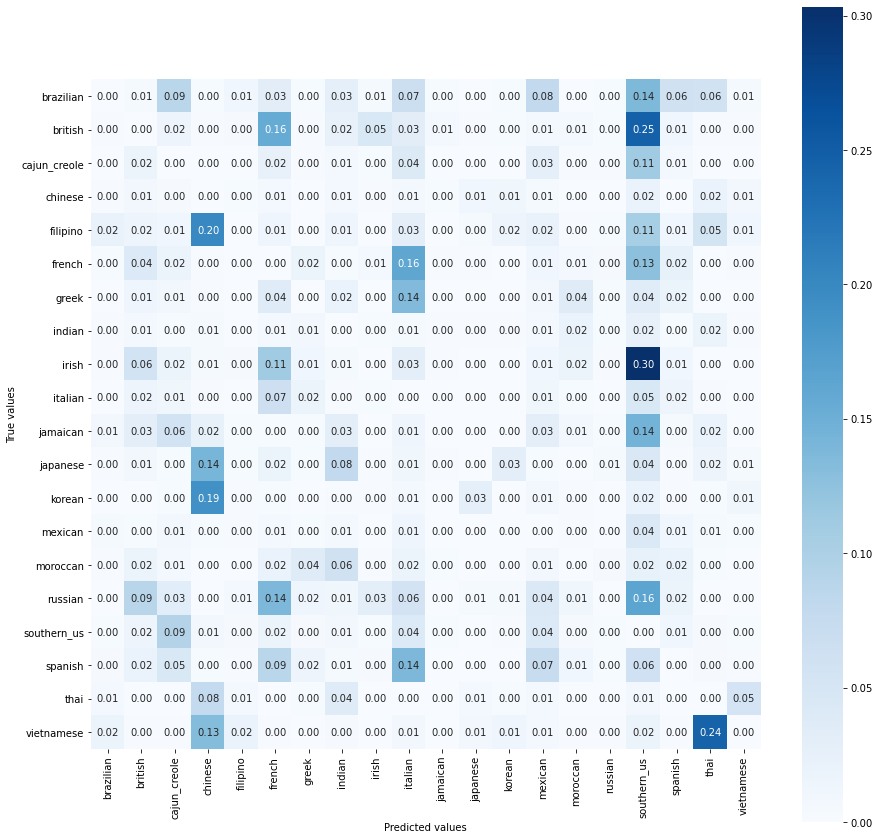

In [78]:
plot_custom_cm(clf, X_train, y_train, normalize=True, fill_diag=True);

Removing stopwords, named entities (and/or lemmetization) does not improve the model performance.

## TF-IDF

In [88]:
ingredients = recipies['ingredients'].apply(' '.join)

X = ingredients.copy()
y = recipies.cuisine.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [89]:
# Let's start with a simple baseline
clf = MultinomialNB()
clf.fit(X_train, y_train)
cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.67210333, 0.67952103, 0.68102961])

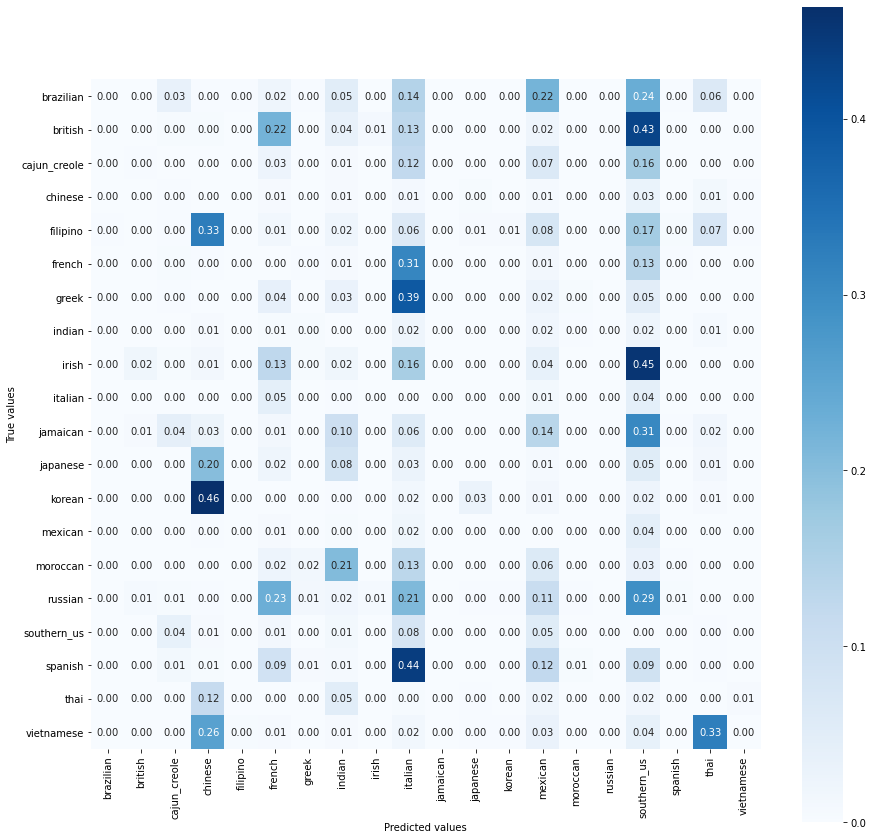

In [90]:
plot_custom_cm(clf, X_train, y_train, normalize=True, fill_diag=True);

TF-IDF vectorization does not improve model either.

## Other Classifiers on Bag of Words

In [92]:
ingredients = recipies['ingredients'].apply(' '.join)

In [93]:
X = ingredients.copy()
y = recipies.cuisine.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [94]:
bago = CountVectorizer(min_df=5)
X_train = bago.fit_transform(X_train)
X_test = bago.transform(X_test)

In [59]:
clf = LogisticRegression(max_iter=500)
print(cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy'))
print('Time to fit:', timeit.timeit('clf.fit(X_train, y_train)', 'from __main__ import clf, X_train, y_train', number=1))

[0.77194306 0.77493871 0.77456157]
Time to fit: 13.026433799997903


In [60]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
print(cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy'))
print('Time to fit:', timeit.timeit('clf.fit(X_train, y_train)', 'from __main__ import clf, X_train, y_train', number=1))

[0.7397002  0.74674712 0.74372996]
Time to fit: 37.23317719999977


In [61]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf')
print(cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy'))
print('Time to fit:', timeit.timeit('clf.fit(X_train, y_train)', 'from __main__ import clf, X_train, y_train', number=1))

[0.75864995 0.76899868 0.75938148]
Time to fit: 86.56864990000031


In [62]:
clf = xgb.XGBClassifier()
print(cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy'))
print('Time to fit:', timeit.timeit('clf.fit(X_train, y_train)', 'from __main__ import clf, X_train, y_train', number=1))

[0.78221929 0.78502734 0.78106732]
Time to fit: 10.20999909999955


In [63]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
print(cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy'))
print('Time to fit:', timeit.timeit('clf.fit(X_train, y_train)', 'from __main__ import clf, X_train, y_train', number=1))

[0.71405675 0.72091269 0.71959268]
Time to fit: 0.1303769000005559


In [64]:
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
print(cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy'))
print('Time to fit:', timeit.timeit('clf.fit(X_train, y_train)', 'from __main__ import clf, X_train, y_train', number=1))

[0.67728858 0.68395248 0.68819536]
Time to fit: 0.14072120000128052


XGBoost and Logistic Regression perform slightly better than the rest but Naive Bayes methods are much faster!

## Dimensionality Reduciton.

Dimensionality reduction is often used in text analysis because bag of words (or TF-IDF) genrates a sparse matrix with a lot of features (1766 in this case). So, let's give that a try.

In [95]:
tsvd = TruncatedSVD(n_components=1765)
tsvd.fit(X_train)

TruncatedSVD(n_components=1765)

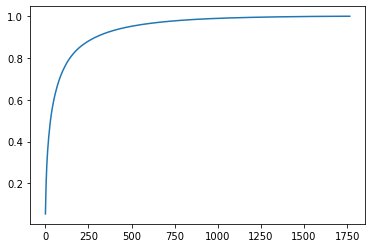

In [96]:
cumsum = np.cumsum(tsvd.explained_variance_ratio_)
sns.lineplot(x=np.arange(1,len(cumsum)+1), y=cumsum);

In [97]:
d = np.argmax(cumsum>=0.9)+1
tsvd = TruncatedSVD(n_components=d)
X_reduced = tsvd.fit_transform(X_train)

In [99]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_reduced, y_train)
cross_val_score(clf, X_reduced, y_train, cv=3, scoring='accuracy')

array([0.70396908, 0.71553837, 0.71016406])

Dimensionality reduction decreases the accuracy significantly and also reduces interpretability of the model. It is harder to understand which ingredients are driving factors. It is also not possible to use Naive Bayes methods (which are faster) with SVD because of the independence assumption. So let's go back to our original Bag of Words features and tune the XGBoost model.

## XGBoost Model Tuning